In [1]:
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *
from self_supervised.swav import *
from fastai.callback.wandb import WandbCallback
import wandb

## Pretraining

In [2]:
sqrmom=0.99
mom=0.95
beta=0.
eps=1e-4
opt_func = partial(ranger, mom=mom, sqr_mom=sqrmom, eps=eps, beta=beta)

In [3]:
def get_dls(size, bs, workers=None):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    
    files = get_image_files(source)
    tfms = [[PILImage.create, ToTensor, RandomResizedCrop(size, min_scale=0.9)], 
            [parent_label, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=RandomSplitter(valid_pct=0.1)(files))
    
    batch_tfms = [IntToFloatTensor]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    return dls

In [4]:
bs=128
resize, size = 160, 128

In [5]:
arch = "xresnet34"
encoder = create_encoder(arch, pretrained=False, n_in=3)

In [ ]:
xtra_config = {"Arch":arch, "Resize":resize, "Size":size, "Algorithm":"SWAV"}
wandb.init(project="self-supervised-imagewang", config=xtra_config)

In [7]:
dls = get_dls(resize, bs)
model = create_swav_model(encoder, n_in=3)
learn = Learner(dls, model, SWAVLoss(),
                cbs=[SWAV(aug_func=get_batch_augs,
                          crop_sizes=[size,96], 
                          num_crops=[2,6],
                          min_scales=[0.25,0.2],
                          max_scales=[1.0,0.35],                
                          rotate=True,
                          rotate_deg=10,
                          jitter=True,
                          bw=True,
                          blur=False
                          ),
                     TerminateOnNaNCallback(),
                     WandbCallback(log_preds=False,log_model=False)
                     ])

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> Rotate -- {'size': None, 'mode': 'b

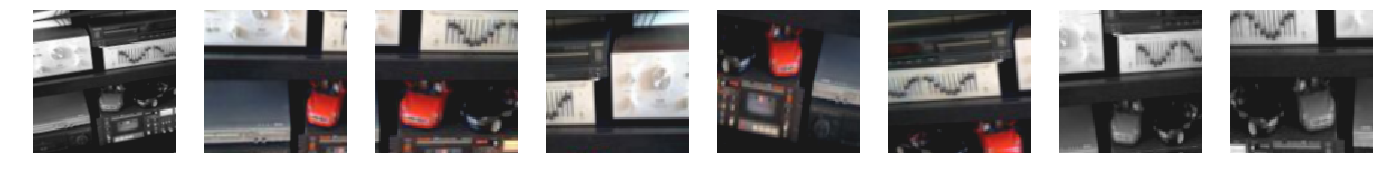

In [8]:
b = dls.one_batch()
learn._split(b)
learn('before_batch')
learn.swav.show_one()

In [9]:
learn.to_fp16();

In [10]:
# learn.lr_find()

In [11]:
lr=1e-2
wd=1e-2
epochs=100

In [12]:
learn.unfreeze()
learn.fit_flat_cos(epochs, lr, wd=wd, pct_start=0.5)

epoch,train_loss,valid_loss,time
0,7.562223,7.556176,01:28
1,7.256415,7.216019,01:24
2,7.002712,7.094245,01:24
3,6.810123,6.977897,01:25
4,6.670819,6.838521,01:24
5,6.498086,6.639339,01:26
6,6.344620,6.492225,01:25
7,6.203028,6.306142,01:26
8,6.122333,6.169743,01:26
9,6.027206,6.147151,01:24


In [13]:
wandb.finish()

epoch,100
train_loss,4.739
raw_loss,4.62989
wd_0,0.01
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.9
eps_0,1e-05
_step,18499
_runtime,8546
_timestamp,1612738544


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▇▆▅▄▄▄▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
raw_loss,██▆▅▄▄▄▄▃▄▃▃▃▃▃▃▃▃▃▄▃▃▃▃▃▂▂▃▃▂▂▂▂▂▂▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,████████████████████████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁
mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [14]:
save_name = f'swav_iwang_sz{size}_epc{epochs}'
learn.save(save_name)
torch.save(learn.model.encoder.state_dict(), learn.path/learn.model_dir/f'{save_name}_encoder.pth')

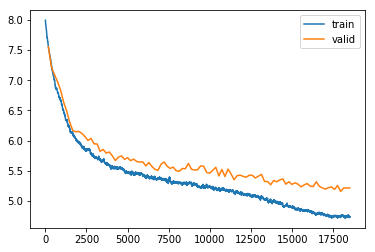

In [15]:
learn.recorder.plot_loss()

## Downstream Task

In [29]:
bs, size

(128, 128)

In [17]:
def get_dls(size, bs, workers=None):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    files = get_image_files(source, folders=['train', 'val'])
    splits = GrandparentSplitter(valid_name='val')(files)
    
    item_aug = [RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)]
    tfms = [[PILImage.create, ToTensor, *item_aug], 
            [parent_label, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=splits)
    
    batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    return dls

In [51]:
def split_func(m): return L(m[0], m[1]).map(params)

def create_learner(size=size, arch='xresnet34', encoder_path="models/swav_iwang_sz128_epc100_encoder.pth"):
    
    dls = get_dls(size, bs=bs//2)
    pretrained_encoder = torch.load(encoder_path)
    encoder = create_encoder(arch, pretrained=False, n_in=3)
    encoder.load_state_dict(pretrained_encoder)
    nf = encoder(torch.randn(2,3,224,224)).size(-1)
    classifier = create_cls_module(nf, dls.c)
    model = nn.Sequential(encoder, classifier)
    learn = Learner(dls, model, opt_func=opt_func, splitter=split_func,
                metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy())
    return learn

In [52]:
def finetune(size, epochs, arch, encoder_path, lr=1e-2, wd=1e-2):
    learn = create_learner(size, arch, encoder_path)
    learn.unfreeze()
    learn.fit_flat_cos(epochs, lr, wd=wd)
    final_acc = learn.recorder.values[-1][-2]
    return final_acc

### 5 epochs

In [ ]:
acc = []
runs = 5
for i in range(runs): acc += [finetune(size, epochs=5, arch='xresnet34', encoder_path=f'models/swav_iwang_sz{size}_epc100_encoder.pth')]

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.004153,1.726009,0.634258,0.927208,00:27
1,0.952761,1.601531,0.666073,0.914228,00:26
2,0.902247,1.522821,0.684398,0.932553,00:27
3,0.852205,1.578140,0.676763,0.917282,00:26
4,0.776530,1.387038,0.733265,0.944261,00:26


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.992634,1.793369,0.635022,0.903283,00:26
1,0.953077,1.641586,0.659710,0.912700,00:26
2,0.913724,1.780718,0.600407,0.878850,00:26
3,0.853015,1.528081,0.688979,0.929244,00:26
4,0.782257,1.390942,0.722576,0.938152,00:27


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


In [ ]:
np.mean(acc)

### 20 epochs

In [ ]:
acc = []
runs = 3
for i in range(runs): acc += [finetune(size, epochs=20, arch='xresnet34', encoder_path=f'models/swav_iwang_sz{size}_epc100_encoder.pth')]
np.mean(acc)

### 80 epochs

In [ ]:
acc = []
runs = 1
for i in range(runs): acc += [finetune(size, epochs=80, arch='xresnet34',encoder_path=f'models/swav_iwang_sz{size}_epc100_encoder.pth')]
np.mean(acc)

### 200 epochs

In [ ]:
acc = []
runs = 1
for i in range(runs): acc += [finetune(size, epochs=200, arch='xresnet34', encoder_path=f'models/swav_iwang_sz{size}_epc100_encoder.pth')]
np.mean(acc)